In [1]:
using_colab = True

In [3]:
import cv2
import os

def extract_frames(video_path, output_folder):
    """
    Extracts all frames from a video and saves them as images in the specified folder.

    Args:
        video_path (str): Path to the input video file.
        output_folder (str): Path to the folder where the extracted frames will be saved.
    """

    os.makedirs(output_folder, exist_ok=True)

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    frame_idx = 0
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        frame_filename = os.path.join(output_folder, f"{frame_idx:05d}.jpg")
        cv2.imwrite(frame_filename, frame)
        print(f"Saved: {frame_filename}")
        frame_idx += 1

    cap.release()
    print(f"Extraction complete. Total frames saved: {frame_idx}")

video_path = "test.mp4"
output_folder = "hands/"
extract_frames(video_path, output_folder)

Saved: hands/00000.jpg
Saved: hands/00001.jpg
Saved: hands/00002.jpg
Saved: hands/00003.jpg
Saved: hands/00004.jpg
Saved: hands/00005.jpg
Saved: hands/00006.jpg
Saved: hands/00007.jpg
Saved: hands/00008.jpg
Saved: hands/00009.jpg
Saved: hands/00010.jpg
Saved: hands/00011.jpg
Saved: hands/00012.jpg
Saved: hands/00013.jpg
Saved: hands/00014.jpg
Saved: hands/00015.jpg
Saved: hands/00016.jpg
Saved: hands/00017.jpg
Saved: hands/00018.jpg
Saved: hands/00019.jpg
Saved: hands/00020.jpg
Saved: hands/00021.jpg
Saved: hands/00022.jpg
Saved: hands/00023.jpg
Saved: hands/00024.jpg
Saved: hands/00025.jpg
Saved: hands/00026.jpg
Saved: hands/00027.jpg
Saved: hands/00028.jpg
Saved: hands/00029.jpg
Saved: hands/00030.jpg
Saved: hands/00031.jpg
Saved: hands/00032.jpg
Saved: hands/00033.jpg
Saved: hands/00034.jpg
Saved: hands/00035.jpg
Saved: hands/00036.jpg
Saved: hands/00037.jpg
Saved: hands/00038.jpg
Saved: hands/00039.jpg
Saved: hands/00040.jpg
Saved: hands/00041.jpg
Saved: hands/00042.jpg
Saved: hand

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-2tn5hrrl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-2tn5hrrl
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.8 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp311-cp

In [4]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

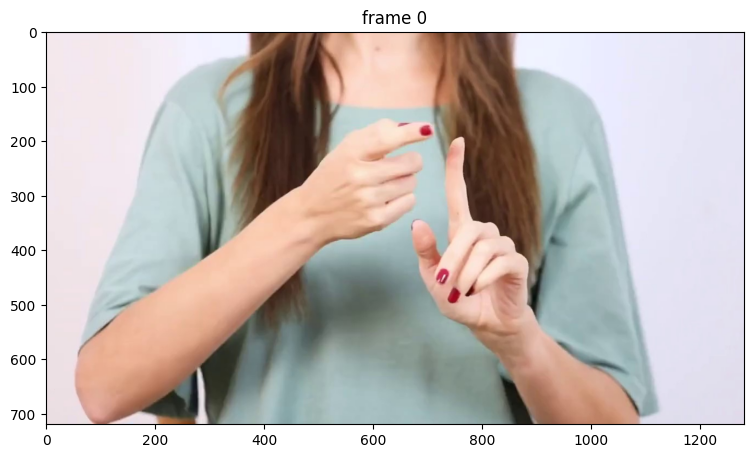

In [9]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./hands"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [10]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 210/210 [00:09<00:00, 22.52it/s]


In [ ]:
predictor.reset_state(inference_state)

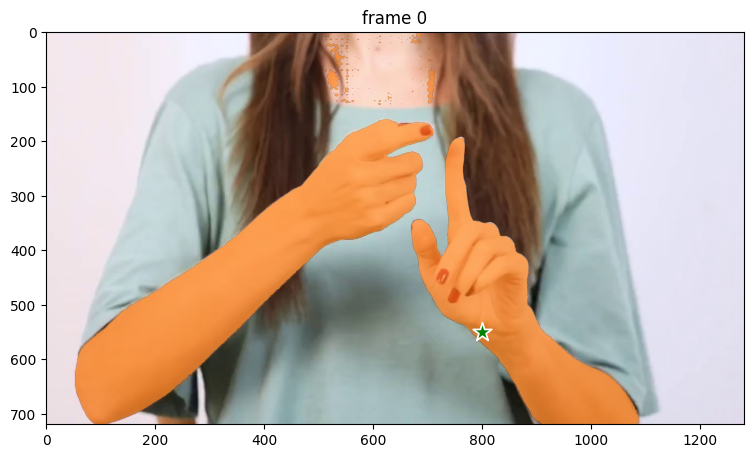

In [12]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[800, 550]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [13]:
import json
bbox = json.load(open("bounding_boxes.json"))

In [14]:
bbox

{'0': [[484.4260787963867,
   177.6177477836609,
   697.4373626708984,
   351.43441915512085],
  [691.6870880126953,
   210.77197551727295,
   869.7132873535156,
   548.9574193954468]],
 '1': [[490.11932373046875,
   176.74477458000183,
   704.8494720458984,
   347.74445056915283],
  [691.639404296875,
   212.34111070632935,
   872.0694732666016,
   546.5121459960938]],
 '2': [[492.9097366333008,
   176.42789840698242,
   710.0383758544922,
   345.5890488624573],
  [691.0186767578125, 206.970534324646, 871.8983459472656, 541.1011219024658]],
 '3': [[497.4211120605469,
   171.97773814201355,
   712.3902130126953,
   341.235888004303],
  [688.7297821044922,
   202.49008655548096,
   872.6413726806641,
   535.7259321212769]],
 '4': [[499.9217987060547,
   168.92496585845947,
   714.6425628662109,
   338.71527671813965],
  [689.4974517822266,
   196.25712633132935,
   873.5892486572266,
   530.6246709823608]],
 '5': [[501.2336730957031,
   166.32546544075012,
   714.9825286865234,
   335.7

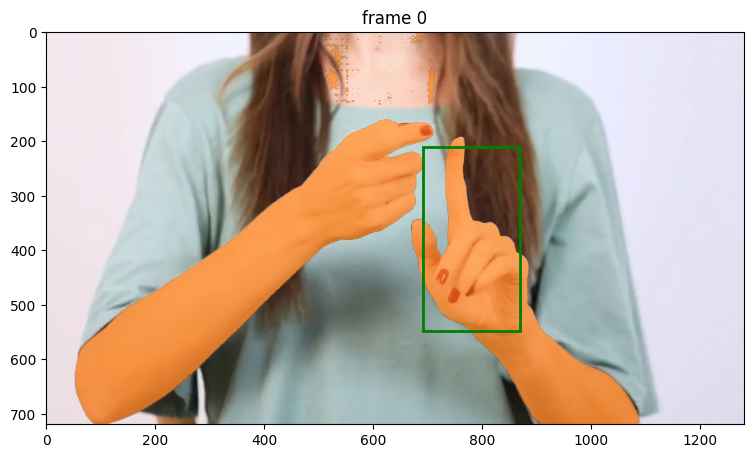

In [15]:
ann_frame_idx = 0  # the frame on which we add bounding boxes

# for each bounding box on frame 0, add it as a new object prompt
for i, box_coords in enumerate(bbox['0']):
    obj_id = 100 + i  # unique integer ID for each object
    box = np.array(box_coords, dtype=np.float32)

    # add_new_points_or_box returns the new mask(s) on this frame
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=obj_id,
        box=box
    )
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [16]:
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    # out_frame_idx: the frame index
    # out_obj_ids: list of object IDs that have a mask on this frame
    # out_mask_logits: list of mask logits for those objects
    masks = [(out_mask_logits[i] > 0.0).cpu().numpy() for i in range(len(out_obj_ids))]

    # store in a dictionary
    video_segments[out_frame_idx] = dict(zip(out_obj_ids, masks))


propagate in video: 100%|██████████| 210/210 [05:50<00:00,  1.67s/it]


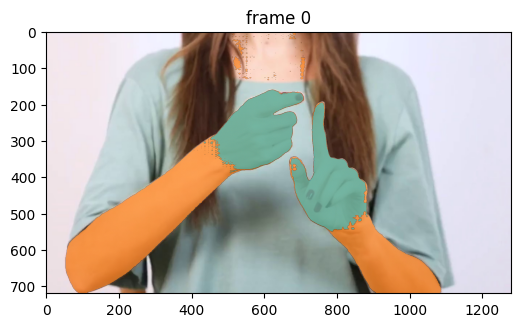

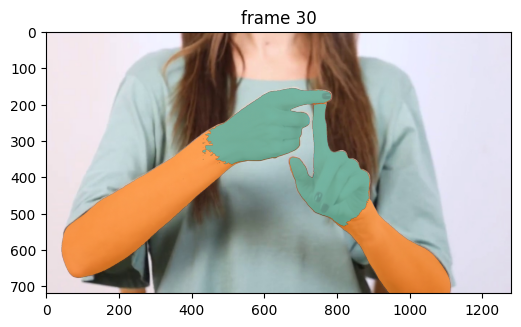

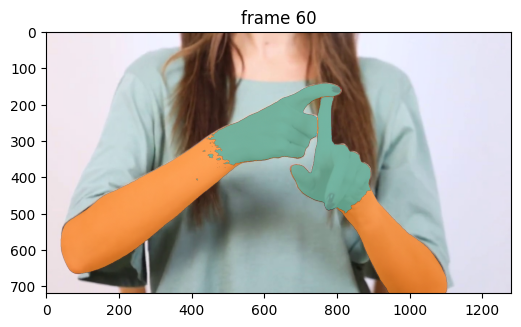

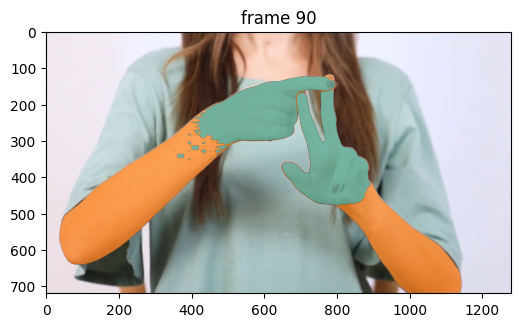

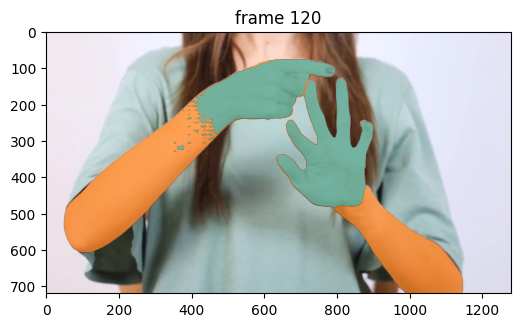

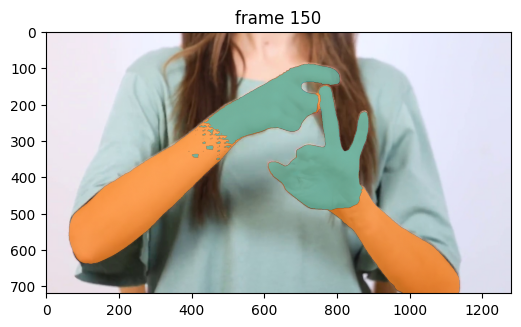

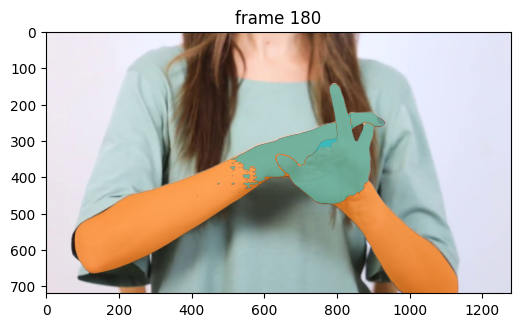

In [19]:
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)